# 📊 Data Processing

In [2]:
# Use the same kernal with Step 0
import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler

## Raw data processing 

In [3]:
df = pd.read_csv(file)
df = df[["date"] + target]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [4]:
# Convert to datetime 
df["date"] = pd.to_datetime(df["date"])

# Handling missing values
df[target] = df[target].interpolate()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB


In [5]:
df.head(10)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
5,2013-01-06,7.000000,82.800000,1.480000,1018.000000
6,2013-01-07,7.000000,78.600000,6.300000,1020.000000
7,2013-01-08,8.857143,63.714286,7.142857,1018.714286
8,2013-01-09,14.000000,51.250000,12.500000,1017.000000
9,2013-01-10,11.000000,62.000000,7.400000,1015.666667


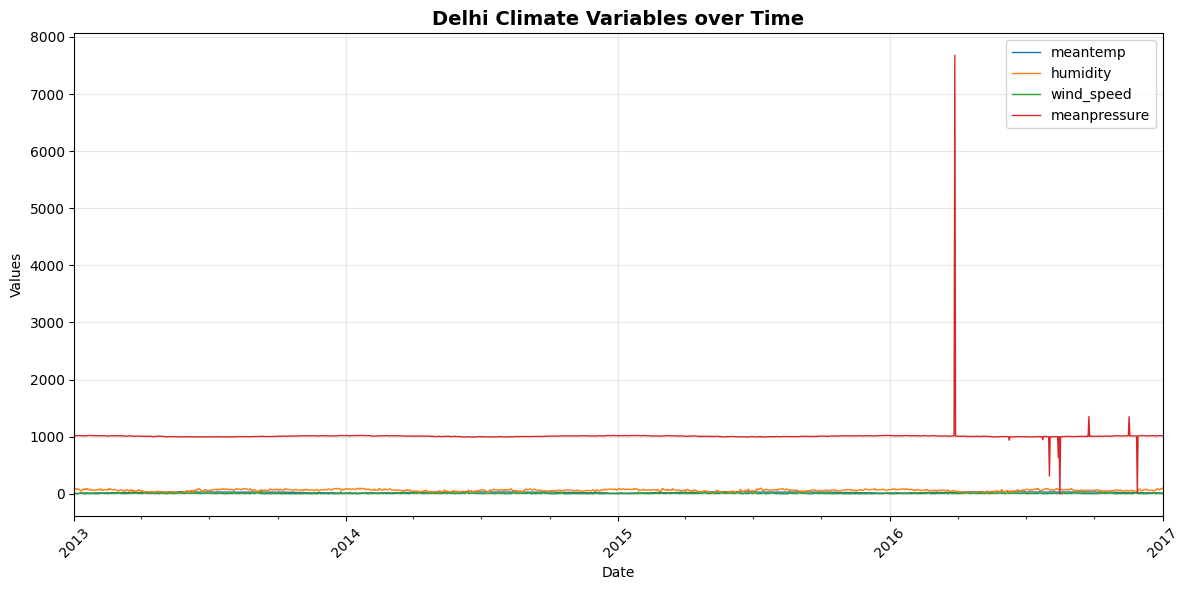

In [6]:
# Plot multiple target columns over time using Pandas built-in plotting
df.set_index("date")[target].plot(figsize=(12, 6), linewidth=1)

# Label for X-axis
plt.xlabel("Date")

# Label for Y-axis (can be a generic name or specific depending on your target)
plt.ylabel(target_name_for_plot)

# Title of the plot
plt.title(name_of_plot, fontsize=14, fontweight="bold")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a light grid to the background
plt.grid(True, alpha=0.3)

# Adjust layout to avoid overlap between labels, title, etc.
plt.tight_layout()

# Display the plot
plt.show()


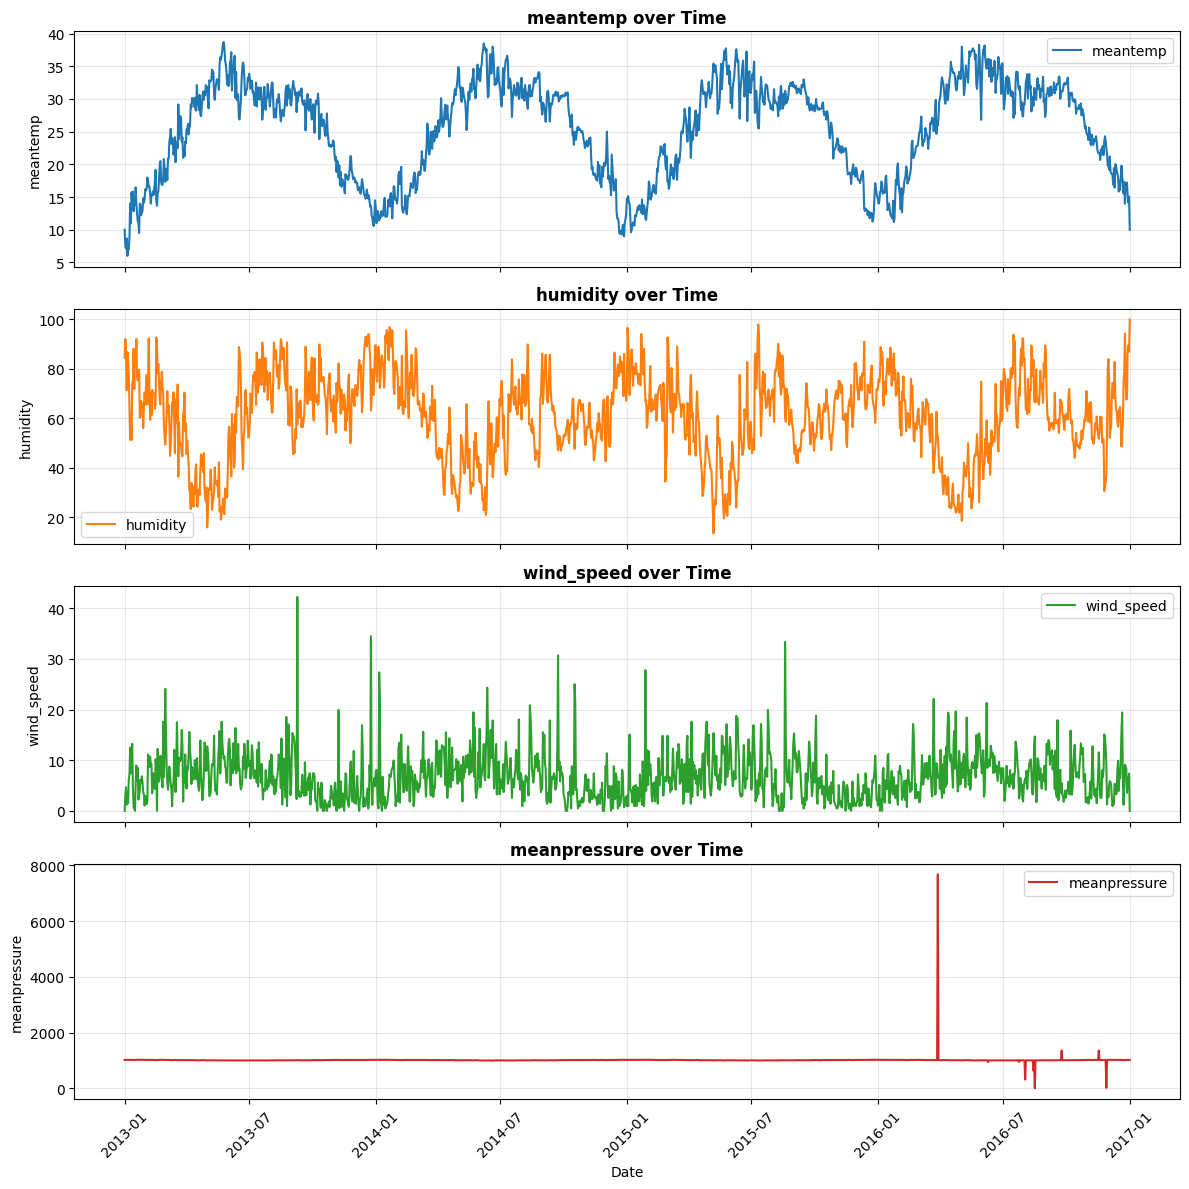

In [7]:
# Number of variables to plot
n_vars = len(target)

# Create subplots (one row per variable)
fig, axes = plt.subplots(nrows=n_vars, ncols=1, figsize=(12, 3*n_vars), sharex=True)

# Plot each variable in its own subplot
for i, col in enumerate(target):
    axes[i].plot(df["date"], df[col], label=col, color="C"+str(i), linewidth=1.5)
    axes[i].set_title(f"{col} over Time", fontsize=12, fontweight="bold")
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

# Set X-axis label only on the last subplot
axes[-1].set_xlabel("Date")
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## Train-Test Split

In [8]:
# Set the ratio for training set
train_ratio = 0.8  # 80% train, 20% test

# Get the total number of samples
num_samples = len(df)

# Split into train and test (keep both "date" and target columns in training set)
data_train = df[:int(num_samples * train_ratio)]
data_test = df.iloc[int(num_samples * train_ratio):]

# Select only target columns for training and testing
y_train = data_train[target]
y_test = df[target][int(num_samples * train_ratio):]


In [9]:
print(len(df))
print(len(y_train))
print(len(y_test))

1462
1169
293


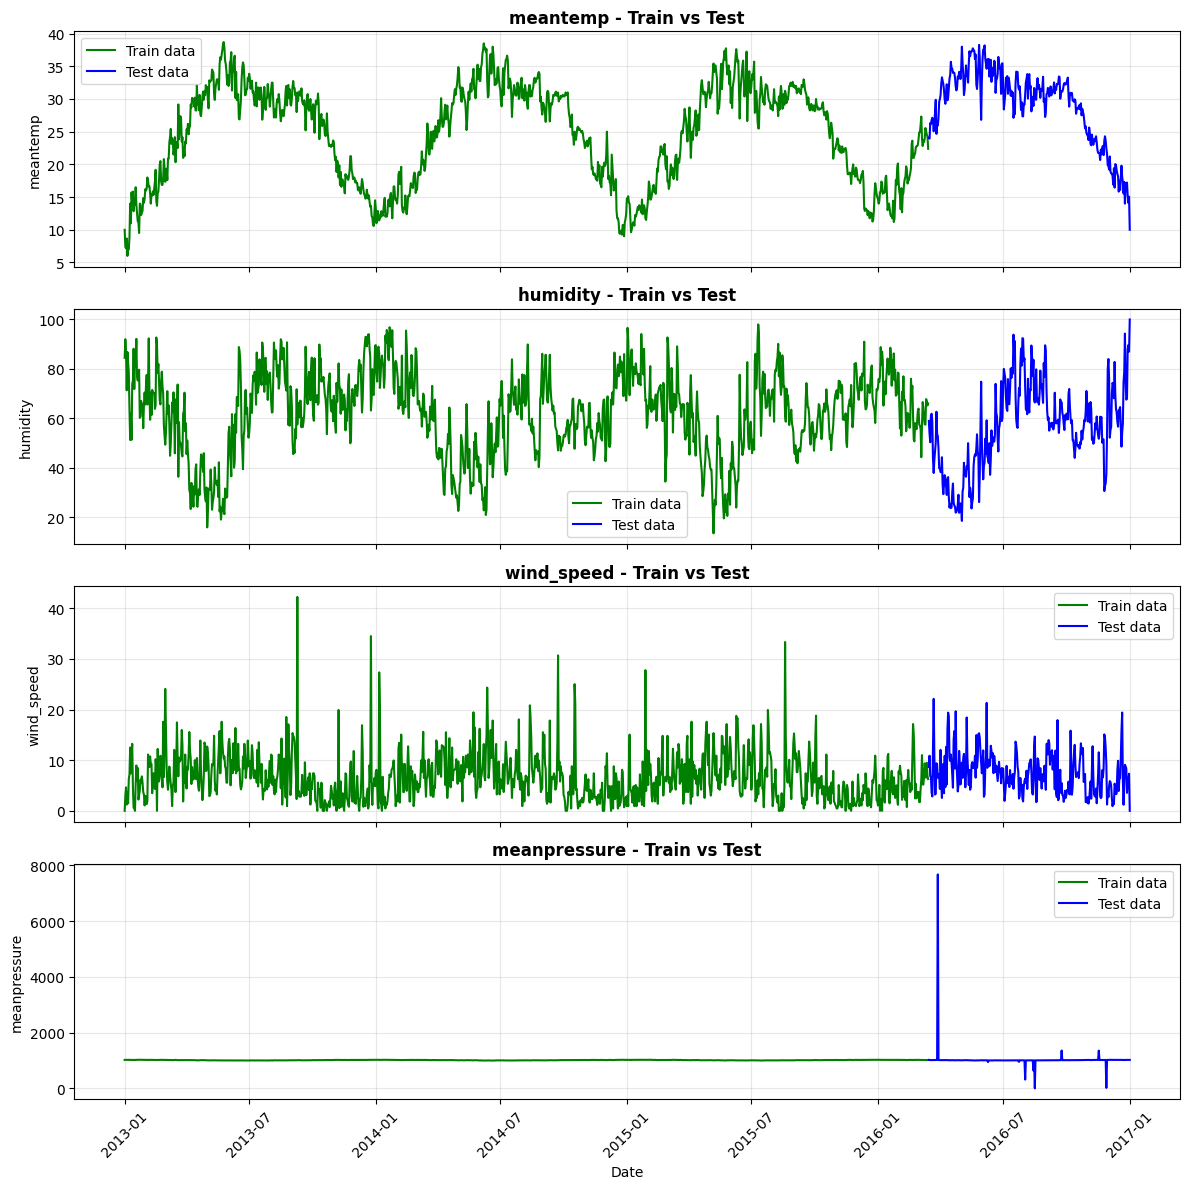

In [10]:
# Number of variables to plot
n_vars = len(target)

fig, axes = plt.subplots(nrows=n_vars, ncols=1, figsize=(12, 3*n_vars), sharex=True)

# Plot each variable separately
for i, col in enumerate(target):
    axes[i].plot(df['date'][:int(num_samples * train_ratio)], 
                 df[col][:int(num_samples * train_ratio)], 
                 'green', label='Train data')
    
    axes[i].plot(df['date'][int(num_samples * train_ratio):], 
                 df[col][int(num_samples * train_ratio):], 
                 'blue', label='Test data')
    
    axes[i].set_title(f"{col} - Train vs Test", fontsize=12, fontweight="bold")
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

# X-axis label only at the bottom
axes[-1].set_xlabel("Date")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [11]:
y_train.head()

,meantemp,humidity,wind_speed,meanpressure
0,10.000000,84.500000,0.000000,1015.666667
1,7.400000,92.000000,2.980000,1017.800000
2,7.166667,87.000000,4.633333,1018.666667
3,8.666667,71.333333,1.233333,1017.166667
4,6.000000,86.833333,3.700000,1016.500000


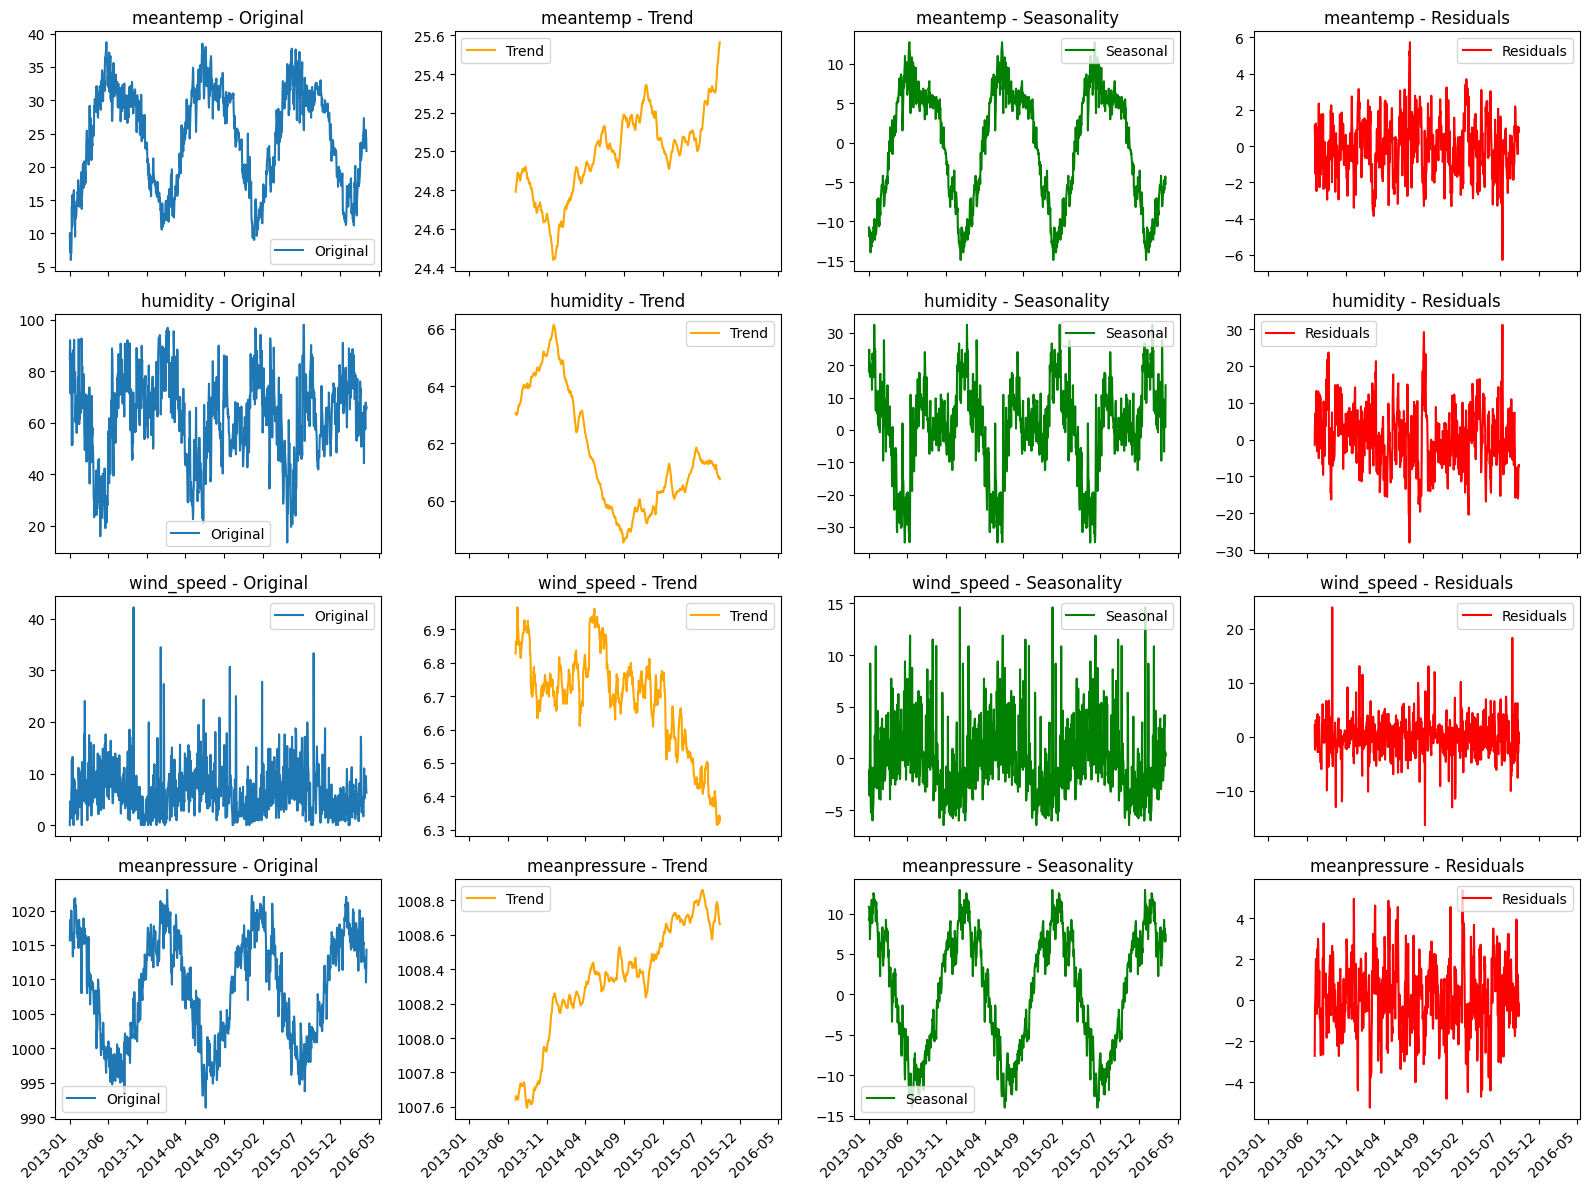

In [12]:
# Set period according to data frequency (e.g., 365 for daily yearly data, 24 for hourly daily data)
period = 365  

n_vars = len(target)

# Create subplot grid: each row = one variable, each column = component (Original, Trend, Seasonal, Residual)
fig, axes = plt.subplots(nrows=n_vars, ncols=4, figsize=(16, 3*n_vars), sharex=True)

for i, col in enumerate(target):
    # Decompose the series
    decomposition = seasonal_decompose(data_train[col], model='additive', period=period)
    
    # Original series
    axes[i, 0].plot(data_train["date"], data_train[col], label="Original")
    axes[i, 0].set_title(f"{col} - Original")
    axes[i, 0].legend(loc="best")
    
    # Trend component
    axes[i, 1].plot(data_train["date"], decomposition.trend, label="Trend", color="orange")
    axes[i, 1].set_title(f"{col} - Trend")
    axes[i, 1].legend(loc="best")
    
    # Seasonal component
    axes[i, 2].plot(data_train["date"], decomposition.seasonal, label="Seasonal", color="green")
    axes[i, 2].set_title(f"{col} - Seasonality")
    axes[i, 2].legend(loc="best")
    
    # Residual component
    axes[i, 3].plot(data_train["date"], decomposition.resid, label="Residuals", color="red")
    axes[i, 3].set_title(f"{col} - Residuals")
    axes[i, 3].legend(loc="best")

# Format x-axis: show fewer ticks (e.g., one per month)
for ax in axes[-1, :]:  # only bottom row for readability
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))  # every 2 months
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()


## Normalization

In [13]:
scaler = StandardScaler()

# Standardize training data
X_train_scaled = scaler.fit_transform(data_train[target])

# Create DataFrame for training data (use index from data_train)
df_train_scaled = pd.DataFrame(X_train_scaled, columns=target, index=data_train.index)

# Standardize test data (DO NOT fit, only transform)
X_test_scaled = scaler.transform(data_test[target])

# Create DataFrame for test data (use index from data_test)  
df_test_scaled = pd.DataFrame(X_test_scaled, columns=target, index=data_test.index)

# Print to check
print("✅ Train data scaled:")
print(df_train_scaled)
print(f"Shape: {df_train_scaled.shape}")

print("\n✅ Test data scaled:")  
print(df_test_scaled)
print(f"Shape: {df_test_scaled.shape}")


✅ Train data scaled:
      meantemp  humidity  wind_speed  meanpressure
0    -1.961709  1.370029   -1.415940      0.906445
1    -2.312058  1.823940   -0.776778      1.186218
2    -2.343499  1.521333   -0.422164      1.299876
3    -2.141375  0.573164   -1.151410      1.103160
4    -2.500707  1.511246   -0.622349      1.015731
...        ...       ...         ...           ...
1164  0.135327 -0.267832    0.295911      0.581318
1165  0.068514  0.359321   -0.011784      0.495528
1166  0.000578  0.307122    0.618978      0.105922
1167 -0.041531  0.201209    0.051935      0.319031
1168 -0.294186  0.250383   -0.070052      0.728854

[1169 rows x 4 columns]
Shape: (1169, 4)

✅ Test data scaled:
      meantemp  humidity  wind_speed  meanpressure
1169 -0.066235 -0.177302    0.438632      0.801530
1170 -0.083640 -0.491005    0.917915      0.532139
1171  0.236389 -0.699047    0.051935      0.220673
1172  0.219546 -0.037094    0.023784      0.138708
1173  0.300155 -0.000349   -0.648394      0.06025

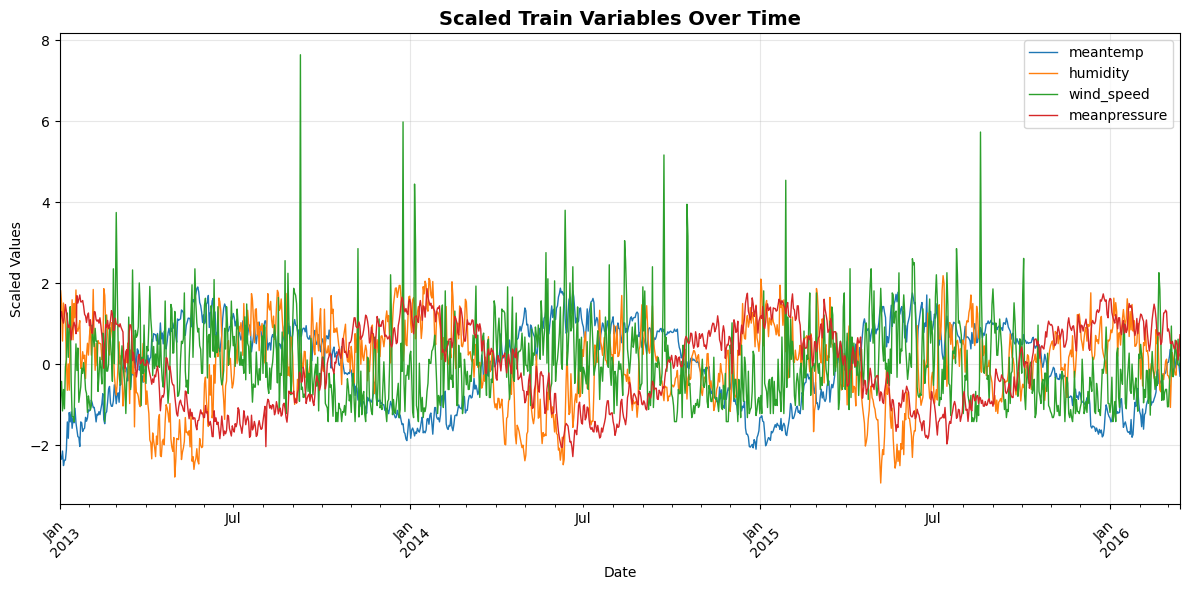

In [16]:
# Plot scaled train data 
df_train_scaled.set_index(data_train["date"]).plot(figsize=(12, 6), linewidth=1)

# Label for X-axis
plt.xlabel("Date")

# Label for Y-axis
plt.ylabel("Scaled Values")  # You can change to target_name_for_plot if needed

# Title of the plot
plt.title("Scaled Train Variables Over Time", fontsize=14, fontweight="bold")  # Adjust name_of_plot

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a light grid to the background
plt.grid(True, alpha=0.3)

# Adjust layout to avoid overlap between labels, title, etc.
plt.tight_layout()

# Display the plot
plt.show()